In [112]:
import numpy as np
from scipy.special import gamma
from sympy import symbols, diff, lambdify
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from typing import Callable

In [113]:
x , y = symbols('x y')
# f = 4*x**2 - 4*x*y + 2*y**2
f = (x**6+y**4-17)**2 + (2*x+y-4)**2

Min = np.array([0,0])
# Min = np.array([1,2])

xm1 = np.array([0.1, 0.5])
x0 = np.array([1.5, 2.5])
# x0= np.random.rand(2) * 3
print(x0)
Xs = [xm1, x0]

tol = 1e-9

beta = 0.1
alpha_f = lambda x: 1 - 2 / np.pi * np.arctan(beta * x)

[1.5 2.5]


In [119]:
def gradient(f) -> Callable[[np.ndarray], np.ndarray]:
    grad_f = [diff(f, var) for var in (x, y)]
    grad_f_lambdified = lambdify((x, y), grad_f)
    return lambda Xk: np.array(grad_f_lambdified(*Xk), dtype=float)

def fractional_grad(f) -> Callable[[np.ndarray, np.ndarray, float], np.ndarray]:
    grad_f = gradient(f)
    return lambda Xk, Xkm1, alpha: grad_f(Xkm1) * abs(Xk - Xkm1)**(1 - alpha) / gamma(2 - alpha)

In [120]:
def descent(f,Xs:list,alpha_f,tol,limit_iter=1000,verbose=False):
    grad_f = gradient(f)
    grad_f_frac = fractional_grad(f)
    ff = lambdify((x, y), f)
    
    alphas = []
    
    for i in range(1,limit_iter):
        Xk = Xs[i]
        Xkm1 = Xs[i-1]
        J = np.linalg.norm(grad_f(Xkm1))
        alpha = alpha_f(J)
        alphas.append(alpha)
        
        grad_frac = grad_f_frac(Xk, Xkm1, alpha)
        if np.linalg.norm(grad_frac) < tol:
            print(f"Converged at iteration {i}: Xk = {Xk}, J = {J}, alpha = {alpha}")
            break
        
        h = minimize_scalar(
            lambda h: ff(*(Xk - h * grad_frac)),
            bounds=(-0.5, 2), method='bounded',
        ).x

        Xkp1 = Xk - h * grad_frac
        Xs.append(Xkp1)
        
        if verbose:
            print(f"Iteration {i}: h = {h}, Xk = {Xk}, grad_frac = {grad_frac},alpha = {alpha}")
        
    return Xs[-1] , grad_frac , alpha, h , i , alphas
        

In [121]:
Xk , fractional_gradient , alpha1_val , optimal_h , i , alphas = descent(f,Xs,alpha_f,tol,verbose=True)

Iteration 1: h = -0.013636966293247248, Xk = [1.5 2.5], grad_frac = [-18.52367416 -43.52657816],alpha = 0.22591117378409942
Iteration 2: h = -1.3186873123260932e-06, Xk = [1.24739328 1.90642952], grad_frac = [ 773.27288127 2486.76205302],alpha = 0.0012288047234788602
Iteration 3: h = 0.04558246348360958, Xk = [1.24841298 1.90970878], grad_frac = [ 0.52575407 -0.36671046],alpha = 0.9425966715733233
Iteration 4: h = 0.0030859229611279694, Xk = [1.22444782 1.92642435], grad_frac = [1.18878114 1.21187677],alpha = 0.5957919200407253
Iteration 5: h = -0.0001167708928682817, Xk = [1.22077933 1.92268459], grad_frac = [0.36639623 0.53064271],alpha = 0.47413774976241163
Iteration 6: h = 0.010511580217431147, Xk = [1.22082212 1.92274655], grad_frac = [ 0.37828922 -0.38055068],alpha = 0.9407367508434972
Iteration 7: h = 0.025403924453630416, Xk = [1.2168457  1.92674674], grad_frac = [ 0.55949253 -0.38640373],alpha = 0.9424582183298484
Iteration 8: h = 0.002527214487345919, Xk = [1.20263239 1.93656



 Variable alpha and optimize theta (Trained):
X_0: [1.5 2.5]
f(X_0): 1121.361572
Minimum successfully obtained...
Number of Iterations for Convergence: 977
alpha_k: [1.000000]
theta_k (approximate optimal h): -0.000004
X_k: [1. 2.]
f(X_k): 0.000000
Error Approximation: 2.236068


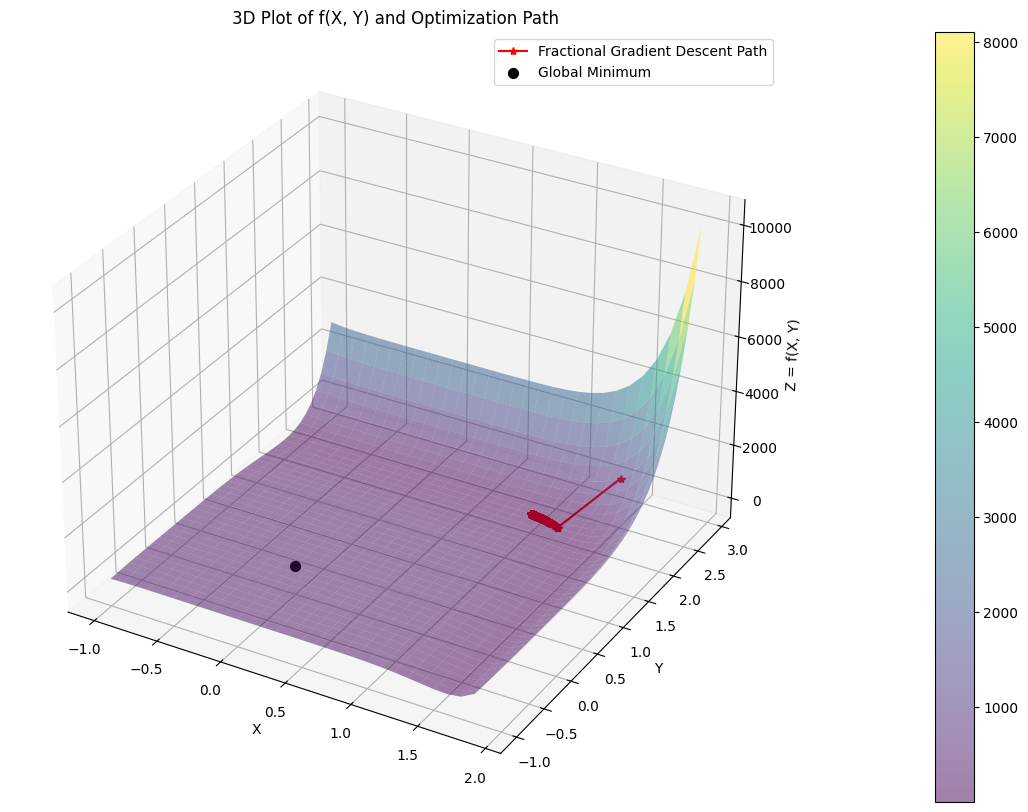

In [122]:
print("\n\n Variable alpha and optimize theta (Trained):")
print(f"X_0: {x0}")
ff = lambdify((x, y), f)
print(f"f(X_0): {ff(*x0):.6f}")
if np.linalg.norm(fractional_gradient) < tol:
    print("Minimum successfully obtained...")
else:
    print("Maximum iterations reached or convergence not achieved.")
print(f"Number of Iterations for Convergence: {i}")
print(f"alpha_k: [{alpha1_val:.6f}]")
print(f"theta_k (approximate optimal h): {optimal_h:.6f}")
print(f"X_k: {Xk}")
print(f"f(X_k): {ff(*Xk):.6f}")
print(f"Error Approximation: {np.linalg.norm(Xk - Min):.6f}")
# Generate level curves for visualization
ff = lambdify((x, y), f, 'numpy')

# Generate data for the 3D plot
delta = 0.1
x_range = np.arange(-1, 2, delta)
y_range = np.arange(-1, 3, delta)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = ff(X_grid, Y_grid)

# Create the 3D plot
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Plot the surface
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', alpha=0.5) # Added alpha
fig.colorbar(surf)  # Add a color bar to the plot
if 'Xs' in locals():
    x_vals = [point[0] for point in Xs[1:]]
    y_vals = [point[1] for point in Xs[1:]]
    z_vals = [ff(point[0], point[1]) for point in Xs[1:]] # Calculate z values
    ax.plot(x_vals, y_vals, z_vals, '*-r', label='Fractional Gradient Descent Path') # plot the path
    ax.scatter(Min[0], Min[1], ff(*Min), color='black', marker='o', s=50, label='Global Minimum') # plot the minimum
else:
    print("Warning: 'Xs' is not defined.  Cannot plot the optimization path.")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z = f(X, Y)')
ax.set_title('3D Plot of f(X, Y) and Optimization Path')
ax.legend()

plt.show()


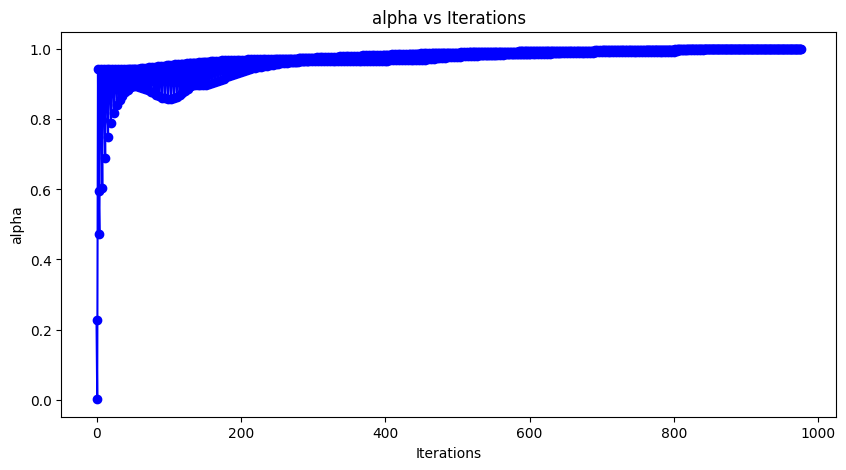

In [123]:
# plot alhpas
plt.figure(figsize=(10, 5))
plt.plot(alphas, marker='o', linestyle='-', color='b')
plt.xlabel('Iterations')
plt.ylabel('alpha')
plt.title('alpha vs Iterations')
plt.show()